In [1]:
import polars as pl
import pandas as pd
import networkx as nx

from ast import literal_eval

In [2]:
# for graph visualization
import numpy as np
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores=scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
data = 'data/arxiv_network_science_data.csv'

In [4]:
%timeit df = pd.read_csv(data)

488 ms ± 58.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit df = pl.read_csv(data)

185 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
df = pl.read_csv(data)
df.head()

date_published,title,authors,summary,url,category
str,str,str,str,str,str
"""2023-11-03 17:34:50+00:00""","""Neural ODEs as a discovery too…","""['Dustin Nguyen', 'Yuan-Sen Ti…","""Dynamic astrophysical phenomen…","""http://arxiv.org/pdf/2311.0205…","""astro-ph.GA"""
"""2023-11-03 15:40:20+00:00""","""Generalization of Graph-Based …","""['Xiaoxiao Wang', 'Joseph Musi…","""Although density functional th…","""http://arxiv.org/pdf/2311.0198…","""cond-mat.mtrl-sci"""
"""2023-11-03 13:10:55+00:00""","""Simulation of acquisition shif…","""['Christiane Posselt', 'Mehmet…","""Purpose: To provide a simulati…","""http://arxiv.org/pdf/2311.0189…","""eess.IV"""
"""2023-11-03 10:40:17+00:00""","""Similarity network aggregation…","""['Roberto Ambrosini', 'Federic…","""The synthesis of information d…","""http://arxiv.org/pdf/2311.0183…","""cs.SI"""
"""2023-11-03 00:33:24+00:00""","""Calibrate and Boost Logical Ex…","""['Yeyuan Chen', 'Dingmin Wang'…","""As a powerful framework for gr…","""http://arxiv.org/pdf/2311.0164…","""cs.LG"""


We can create a bipartite graph with this dataset, using title and authors as our nodes.

In [7]:
edgelist_df = df.select(['title', 'authors'])

authors = [literal_eval(edge) for edge in edgelist_df['authors'].to_list()]

edgelist_df = edgelist_df.select(
    pl.col('title'),
    pl.Series("authors", authors)
)

edgelist_df = edgelist_df.explode('authors')
edgelist_df.columns = ['title', 'author']
edgelist_df.head()

title,author
str,str
"""Neural ODEs as a discovery too…","""Dustin Nguyen"""
"""Neural ODEs as a discovery too…","""Yuan-Sen Ting"""
"""Neural ODEs as a discovery too…","""Todd A. Thompson"""
"""Neural ODEs as a discovery too…","""Sebastian Lopez"""
"""Neural ODEs as a discovery too…","""Laura A. Lopez"""


Question #1: How do we create a networkx graph using this data? 

Idea: Try to shove a polars dataframe right in. lol
Idea: Create a Python list 'edgelist' and use that

I would prefer to be able to just use polars directly, but I doubt that is possible.

In [8]:
G = nx.from_pandas_edgelist(edgelist_df, source='title', target='author')

What?!!! Why did that work? Did it work correctly?

In [9]:
print(G)

Graph with 91659 nodes and 96394 edges


In [10]:
sorted(G.nodes)[0:5]

['"(Weitergeleitet von Journalistin)": The Gendered Presentation of Professions on Wikipedia',
 '"Betweenness Centrality" as an Indicator of the "Interdisciplinarity" of Scientific Journals',
 '"Birds of a Feather": Does User Homophily Impact Information Diffusion in Social Media?',
 '"Breaking" Disasters: Predicting and Characterizing the Global News Value of Natural and Man-made Disasters',
 '"Bring it on": Explaining persistence in science at the intersection of identity and epistemology']

In [11]:
pr_df = pl.DataFrame([nx.pagerank(G)]).transpose(include_header=True)
pr_df.columns = ['node', 'pagerank']
pr_df = pr_df.sort('pagerank', descending=True)
pr_df.head()

node,pagerank
str,f64
"""Detector signal characterizati…",0.000892
"""Unbinned Deep Learning Jet Sub…",0.000781
"""ExoClock project II: A large-s…",0.00055
"""From Data to Software to Scien…",0.00048
"""Photometry of Type II Supernov…",0.000446


In [12]:
components = list(nx.connected_components(G))

len(components[0])

82

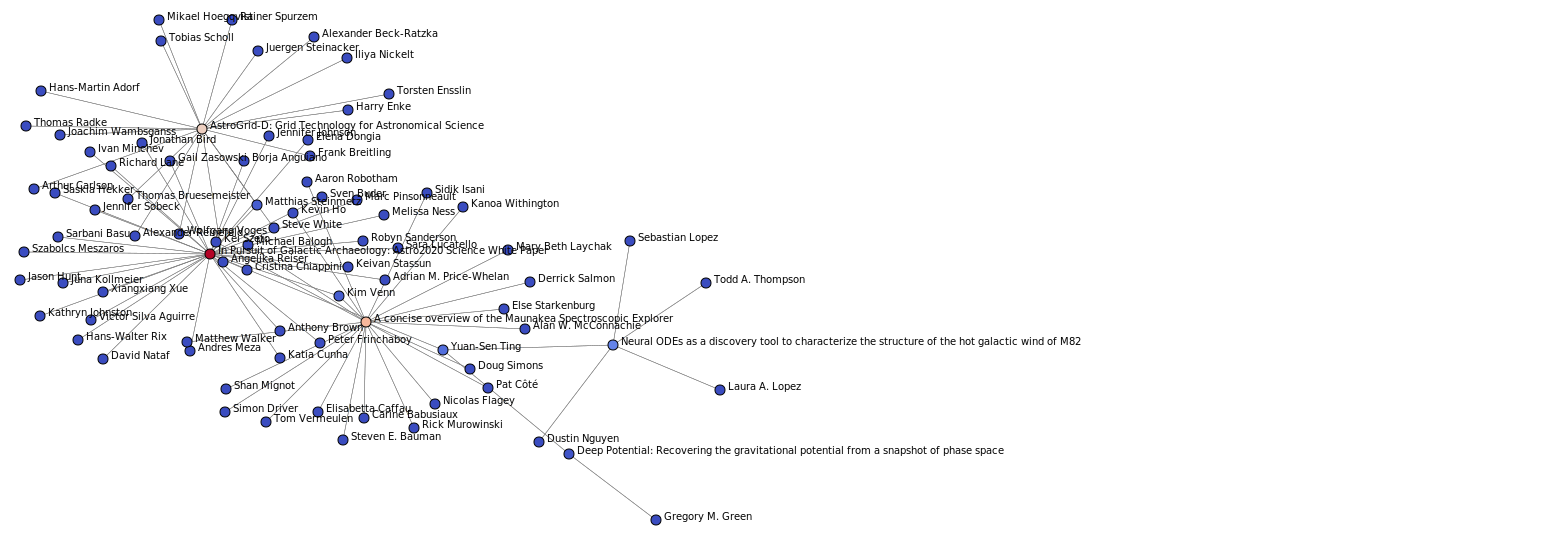

In [13]:
G_check = G.subgraph(components[0])
draw_graph(G_check, node_size=5, show_names=True)

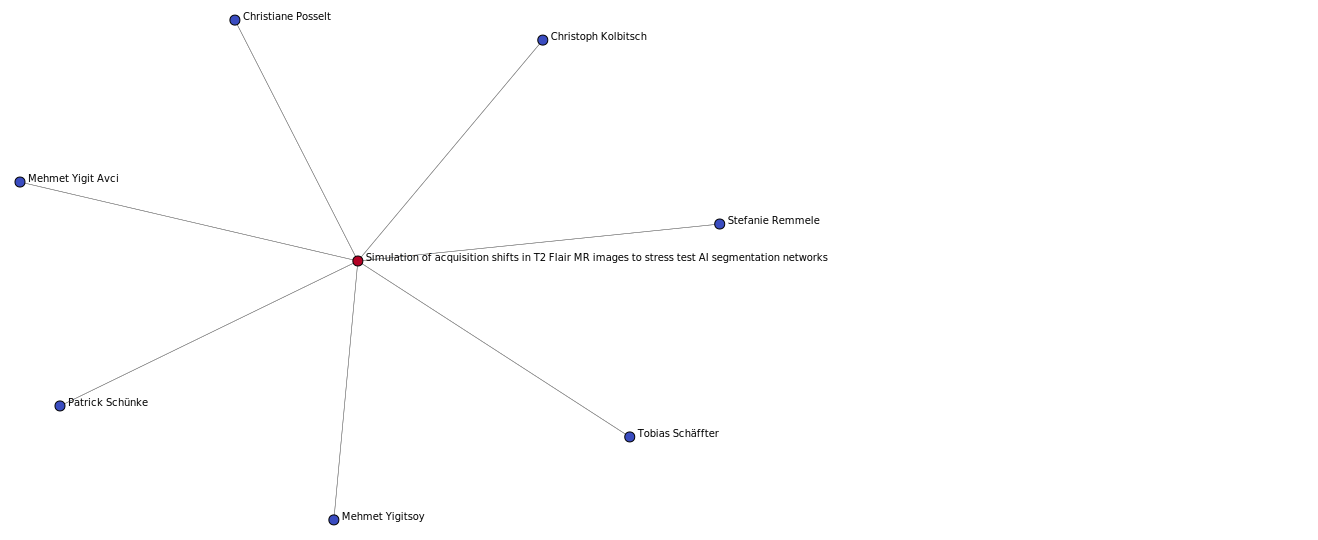

In [14]:
G_check = G.subgraph(components[2])
draw_graph(G_check, node_size=5, show_names=True)

Well, that was easy. That's it. Polars fits right in with Networkx. You can replace your Pandas code with Polars if you prefer. I have no opinion, yet, but am comfortable with Pandas. I will play with Polars. Maybe it speeds up loading a graph. Let's see.

In [15]:
type(edgelist_df)

polars.dataframe.frame.DataFrame

In [16]:
pandas_edgelist_df = edgelist_df.to_pandas()

type(pandas_edgelist_df)

pandas.core.frame.DataFrame

In [17]:
%timeit G = nx.from_pandas_edgelist(edgelist_df, source='title', target='author')

405 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit G = nx.from_pandas_edgelist(pandas_edgelist_df, source='title', target='author')

318 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So far, results are:

Polars is considerably faster for reading data from files

Pandas is a little faster for creating a networkx graph from a dataframe

But, how about for doing some NLP lookups?

In [19]:
%timeit edgelist_df['title'].str.contains('network|central') # filter

10.2 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit pandas_edgelist_df['title'].str.contains('network|central') # filter

212 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit edgelist_df.filter(pl.col("title").str.contains("network|central")) # show, not just filter

10.5 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
edgelist_df.filter(pl.col("title").str.contains("network|central")).head() # showing

title,author
str,str
"""Simulation of acquisition shif…","""Christiane Posselt"""
"""Simulation of acquisition shif…","""Mehmet Yigit Avci"""
"""Simulation of acquisition shif…","""Mehmet Yigitsoy"""
"""Simulation of acquisition shif…","""Patrick Schünke"""
"""Simulation of acquisition shif…","""Christoph Kolbitsch"""


In [23]:
%timeit pandas_edgelist_df[pandas_edgelist_df['title'].str.contains('network|central')] # showing

214 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
pandas_edgelist_df[pandas_edgelist_df['title'].str.contains('network|central')].head()

,title,author
14,Simulation of acquisition shifts in T2 Flair M...,Christiane Posselt
15,Simulation of acquisition shifts in T2 Flair M...,Mehmet Yigit Avci
16,Simulation of acquisition shifts in T2 Flair M...,Mehmet Yigitsoy
17,Simulation of acquisition shifts in T2 Flair M...,Patrick Schünke
18,Simulation of acquisition shifts in T2 Flair M...,Christoph Kolbitsch


In [26]:
214 / 10.5

20.38095238095238

Ok, that's nuts. For doing string lookups, Polars has been consistently more than 20x faster. This is very useful for search and retrieval, and for preprocessing data. That's a good reason to consider using Polars.

As Polars was considerably faster at both loading file data and doing text searches in a DataFrame, I think it's reasonable to consider using Polars instead of Pandas. I plan to try things out. I'm not going to switch yet.